In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import re
import os
import cv2
import timm
import random
import numpy as np
import pandas as pd
import time
%matplotlib inline
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image

In [3]:
def set_seed(seed=22):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# seed 고정
set_seed(22)

# GPU 사용 설정
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    device = 'cpu'
    print('CUDA is not available.  Training on CPU ...')
else:
    device = 'cuda'
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [7]:
class MMC_ClassificationDataset(Dataset):
    def __init__(self, csv, mode, transform=None):
        self.csv = pd.read_csv(csv)
        self.csv = self.csv.reset_index(drop=True)
        self.mode = mode # train / valid
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        row = self.csv.iloc[index]
        image = cv2.imread(row.file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 이미지 tranform 적용
        if self.transform is not None:
            res = self.transform(image=image)
            image = res['image'].astype(np.float32)
        else:
            image = image.astype(np.float32)

        image = image.transpose(2, 0, 1)

        data = torch.tensor(image).float()
        
        if self.mode == 'test':
            return data, row['image_name']
        else:
            target = torch.tensor(row['target'])
            return data, target


In [8]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
import albumentations

transforms_train = albumentations.Compose([
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RandomResizedCrop((224,224)),
        albumentations.Normalize()
        
])

transforms_val = albumentations.Compose([
        albumentations.Resize(256, 256),
        albumentations.CenterCrop(224,224),
        albumentations.Normalize()
])

train_data = MMC_ClassificationDataset('/kaggle/input/2025-id-hallym/train.csv', 'train', transform = transforms_train)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])
validation_dataset.transform = transforms_val

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [9]:
batch_size  = 64
num_workers = 0
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = batch_size, num_workers = num_workers)


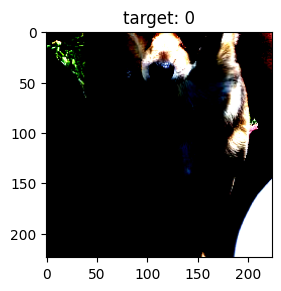

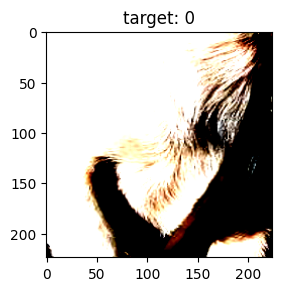

In [10]:
# 데이터셋 확인
for i in range(2):
    d1 = train_data[i]
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(d1[0]).numpy().transpose(1,2,0))
    plt.title('target: ' + str(d1[1].item()))
    plt.show()

In [11]:
# # 사용할 수 있는 모델 확인
# import timm
# timm.list_models(pretrained=True)

In [12]:
class Pretrained_model(nn.Module):
    def __init__(self, out_dim, pretrained=True):
        super(Pretrained_model, self).__init__()
        self.enet = timm.create_model('resnet18.a1_in1k', pretrained=pretrained)

        # 각자 선택한 pretrained model에 따라서 수정 필요
        # Ex) self.enet.fc -> self.enet.classifier
        in_ch = self.enet.fc.in_features
        self.enet.fc = nn.Identity()
        
        self.myfc = nn.Linear(in_ch, out_dim)
    def extract(self, x):
        x = self.enet(x)
        return x

    def forward(self, x, x_meta=None):
        x = self.extract(x)
        out = self.myfc(x)
        return out

In [13]:
model = Pretrained_model(120)

model.to(device)


Pretrained_model(
  (enet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding

In [10]:
learning_rate = 0.01
num_epoch = 10
best_loss = 100
total_train_loss = []
total_val_loss = []
total_train_ACC = []
total_val_ACC = []


In [11]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min')

In [12]:
for i in range(num_epoch):
    # Train
    model.train()
    train_losses = []
    train_PROBS = []
    train_TARGETS = []
    start = time.time()
    for k,(image, label) in enumerate(train_loader):
        
        optimizer.zero_grad()
        image, label = image.to(device), label.to(device)
        logits = model(image)
        
        loss = loss_func(logits, label)

        probs = logits.softmax(1) 

        train_PROBS.append(probs.detach().cpu())
        train_TARGETS.append(label.detach().cpu())
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.cpu().detach().numpy())
        
    train_PROBS = torch.cat(train_PROBS).numpy()
    train_TARGETS = torch.cat(train_TARGETS).numpy()
    train_ACC = (train_PROBS.argmax(1) == train_TARGETS).mean() * 100.
    
    # Evaluation
    model.eval() 
    val_losses = []
    val_PROBS = []
    val_TARGETS = []
    
    for k ,(image, label) in enumerate(validation_loader):
        with torch.no_grad(): 
            image, label = image.to(device), label.to(device)
            logits = model(image)
            loss = loss_func(logits, label)
            
            probs = logits.softmax(1) 

            val_PROBS.append(probs.detach().cpu())
            val_TARGETS.append(label.detach().cpu())
            
            val_losses.append(loss.cpu().detach().numpy())


    val_PROBS = torch.cat(val_PROBS).numpy()
    val_TARGETS = torch.cat(val_TARGETS).numpy()
    val_ACC = (val_PROBS.argmax(1) == val_TARGETS).mean() * 100.



    tran_loss = np.array(train_losses).mean()

    val_loss = np.array(val_losses).mean()
    
    total_train_loss.append(tran_loss)
    total_val_loss.append(val_loss)

    total_train_ACC.append(train_ACC)
    total_val_ACC.append(val_ACC)
    end = time.time() - start
    print(f"Epoch: {str(i)}, Train loss: {tran_loss}, validation loss: {val_loss}, train ACC: {train_ACC}, val ACC: {val_ACC}, t: {end}s")

    scheduler.step(val_loss)

    # 모델 저장
    if(val_loss < best_loss):
        print("Save new param")
        torch.save(model,'./param_' + str(i) + '.pkl')
        best_loss = val_loss

Epoch: 0, Train loss: 4.063004016876221, validation loss: 4.002198696136475, train ACC: 2.7891320028853093, val ACC: 6.730769230769231, t: 38.080891847610474s
Save new param
Epoch: 1, Train loss: 3.965108633041382, validation loss: 3.907524824142456, train ACC: 8.631882664101948, val ACC: 14.038461538461538, t: 38.09820771217346s
Save new param
Epoch: 2, Train loss: 3.8623104095458984, validation loss: 3.794306516647339, train ACC: 16.32603991344073, val ACC: 20.28846153846154, t: 37.44560146331787s
Save new param
Epoch: 3, Train loss: 3.735487699508667, validation loss: 3.6737260818481445, train ACC: 21.92834816061553, val ACC: 26.53846153846154, t: 37.24849843978882s
Save new param
Epoch: 4, Train loss: 3.581725597381592, validation loss: 3.4595553874969482, train ACC: 29.285886030295742, val ACC: 33.17307692307692, t: 38.64542818069458s
Save new param
Epoch: 5, Train loss: 3.4021029472351074, validation loss: 3.274022102355957, train ACC: 36.01827362346718, val ACC: 40.2884615384615

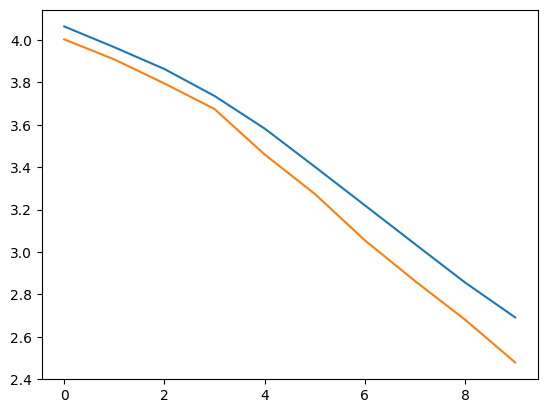

In [13]:
plt.plot(total_train_loss)
plt.plot(total_val_loss)

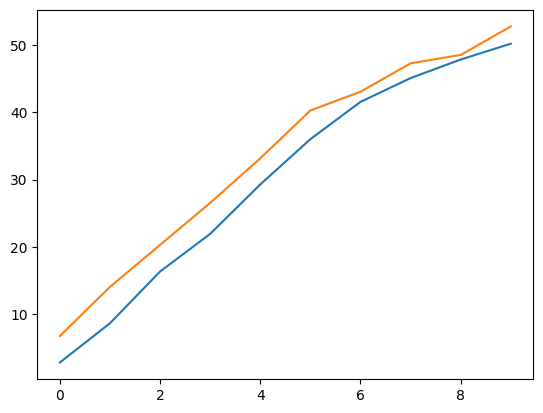

In [14]:
plt.plot(total_train_ACC)
plt.plot(total_val_ACC)

In [15]:
batch_size = 1

test_dataset = MMC_ClassificationDataset('/kaggle/input/2025-id-hallym/test.csv', 'test', transform = transforms_val)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, num_workers = 0, shuffle = True, drop_last = False)

In [16]:
# model = torch.load('/kaggle/working/*****.pkl').to(device)

In [17]:
ids = []
targets = []
model.eval()  
for k ,(image, image_id) in enumerate(test_loader):
    with torch.no_grad(): 
        output = model.forward(image.to(device))
        target = output.argmax(1).item()
        ids.append(image_id[0])
        targets.append(target)

In [ ]:
# 사용할 수 있는 모델 확인
import timm
timm.list_models(pretrained=True)

In [ ]:
class Pretrained_model(nn.Module):
    def __init__(self, out_dim, pretrained=True):
        super(Pretrained_model, self).__init__()
        self.enet = timm.create_model('resnet18.a1_in1k', pretrained=pretrained)

        # 각자 선택한 pretrained model에 따라서 수정 필요
        # Ex) self.enet.fc -> self.enet.classifier
        in_ch = self.enet.fc.in_features
        self.enet.fc = nn.Identity()
        
        self.myfc = nn.Linear(in_ch, out_dim)
    def extract(self, x):
        x = self.enet(x)
        return x

    def forward(self, x, x_meta=None):
        x = self.extract(x)
        out = self.myfc(x)
        return out
        
model = Pretrained_model(120)
model.to(device)

In [5]:
!pip install calflops
from calflops import calculate_flops

In [14]:
# 입력 이미지 shape 반드시 확인
batch_size, image_channel, image_h, image_w = 1, 3, 256, 256
inputs = torch.ones(batch_size, image_channel, image_h, image_w)
flops, macs, params = calculate_flops(model=model, 
                                      input_shape=(1, 3, 256, 256),
                                      output_as_string=False,
                                      print_detailed=False,
                                      output_precision=5)

gflops = round(flops/1000000000,5)

print("내 모델의 FLOPs : ",gflops, "GFLOP")


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  11.24 M 
fwd MACs:                                                               2.36879 GMACs
fwd FLOPs:                                                              4.74817 GFLOPS
fwd+bwd MACs:                                                           7.10638 GMACs
fwd+bwd FLOPs:                                                          14.2445 GFLOPS
---------------------------------------------------------------------------------------------------
내 모델의 FL

In [19]:
submission = pd.DataFrame({'ID': ids, 'target': targets})

In [20]:
file_name=f"/kaggle/working/submission_{gflops}.csv"
submission.to_csv(file_name, index = False)
